In [2]:
import numpy as np
from numpy import linalg
import scipy
from scipy import fftpack
from scipy import optimize
import matplotlib.pyplot as plt
import time
import snap
import prox_tv as ptv

In [3]:
#G = snap.LoadEdgeList(snap.PNEANet, "com-orkut.ungraph.txt", 0, 1)
G = snap.LoadEdgeList(snap.PNEANet, "facebook_combined.txt", 0, 1)
N = G.GetMxNId()
M = G.GetEdges()
print N,M

4039 88234


In [4]:
#The Snake algorithm

def Rnd_Edge(G):
    e = G.GetRndEId()
    e = G.GetEI(e)
    e = list(np.random.permutation([e.GetSrcNId(),e.GetDstNId()]))
    return e

def Uniform_Neib(k,G):
    v = G.GetNI(k)
    k = v.GetNbrNId(np.random.randint(v.GetDeg()))
    return k

def Simple_Path(e,l,G):
    C = e
    k = Uniform_Neib(e[-1],G)
    while (k not in C) and (len(C) < l-1): #Accelerer?
        C += [k]
        k = Uniform_Neib(k,G)
    return C, [C[-1],k]

def Prox_1D(x, C, alpha, R):
    y = np.copy(x)
    res = y.flat[C]
    if R == 'TV':
        res = ptv.tv1_1d(res, alpha, method = 'tautstring')
    elif R == 'Laplace':
        n = len(C)
        res = scipy.fftpack.dct(res, type=2)
        res = res * [1/(1.0 + 4.0*alpha*float(1 - np.cos((np.pi)*float(j) / float(n)) )) for j in range(n)]
        res = 1/(2*float(n))*scipy.fftpack.dct(res, type=3)
    #elif R = 'w_Laplace':
    #elif R = 'Laplace_n':
    y.flat[C] = res
    return y
    

def Snake(G, x, Grad_F, R = 'TV', sec = 10, cte = 1.0, lgr = G.GetNodes()):
    #res = np.copy(x)
    l = lgr
    e = Rnd_Edge(G)
    n = 1
    gamma_n = cte/float(n)
    debut = time.time()
    
    while time.time() - debut < sec:
        C, e = Simple_Path(e, l, G)
        x = x - gamma_n * (len(C) - 1) * Grad_F(x)
        x = Prox_1D(x, C, G.GetEdges()*gamma_n, R)
        l = l - (len(C) - 1)
        if l == 0:
            l = lgr
            n += 1
            gamma_n = cte/float(n)
            e = Rnd_Edge(G)
          
    return x #, n 


In [5]:
#Functions one need to apply the Snake algorithm

#Data fitting term
def Data(x,y):
    return 1/2.0 * np.linalg.norm(x-y)**2

#Gradient of the data fitting term
def Grad_F(x):
    return x - y #coeff

#TV regularization
def TV(x,G):
    r = 0
    for e in G.Edges():
        r += np.abs(x[e.GetSrcNId()] - x[e.GetDstNId()])
    return r

#Estimation of TV with l random edges
def TV_approx(x,G,l):
    r = 0
    for i in range(l):
        e = G.GetRndEId()
        e = G.GetEI(e)
        r += np.abs(x[e.GetSrcNId()] - x[e.GetDstNId()])
    return G.GetEdges()/float(l) * r    

#TV regularized risk
def Obj_TV(x,y,G,lambd = 1.0):
    return lambd * TV(x,G) + Data(x,y)

#Estimation of the TV regularized risk with l random edges
def Obj_TV_approx(x,y,G,l,lambd = 1.0):
    return lambd * TV_approx(x,G,l) + Data(x,y)

#Laplacian regularization
def Laplace(x,G):
    r = 0
    for e in G.Edges():
        r += np.linalg.norm(x[e.GetSrcNId()] - x[e.GetDstNId()])**2
    return r
    
#Estimation of the Laplacian regularization with l random edges
def Laplace_approx(x,G,l):
    r = 0
    for i in range(l):
        e = G.GetRndEId()
        e = G.GetEI(e)
        r += np.linalg.norm(x[e.GetSrcNId()] - x[e.GetDstNId()])**2
    return G.GetEdges()/float(l) * r    

#Laplacian regularized risk
def Obj_Laplace(x,y,G,lambd = 1.0):
    return lambd * Laplace(x,G) + Data(x,y)

#Estimation of the Laplacian regularized risk with l random edges
def Obj_Laplace_approx(x,y,G,l, lambd = 1.0):
    return lambd * Laplace_approx(x,G,l) + Data(x,y)
  
    

In [6]:
#Functions one need to apply the projected gradient algorithm 
#to the dual problem of the TV regularized risk minimization

#Nabla denotes the incidence matrix of G

#Computes the coordinate e of Nabla x
def Nabla_Coord(x,G,e):
    y = np.zeros(G.GetMxEId())
    y[e.GetId()] = x[e.GetSrcNId()] - x[e.GetDstNId()]
    return y


#Computes Nabla x
def Nabla(x,G):
    y = np.zeros(G.GetMxEId())
    for e in G.Edges():
        y[e.GetId()] = x[e.GetSrcNId()] - x[e.GetDstNId()] 
        #e.GetSrcNId() < e.GetDstNId()
    return y

#Computes Nabla.T u
def NablaT(u,G):
    y = np.zeros(G.GetMxNId())
    for v in G.Nodes():
        r = 0
        i = v.GetId()
        for k in range(v.GetDeg()):
            if i < v.GetNbrNId(k):
                e = G.GetEI(i,v.GetNbrNId(k))
                r += u[e.GetId()]
            else:
                e = G.GetEI(v.GetNbrNId(k),i)
                r -= u[e.GetId()]
        y[v.GetId()] = r
    return y


#Objective function of the dual problem of the TV regularized risk minimization
def Objectif_Dual(u,y,G):
    return (1.0/2.0)*(linalg.norm(NablaT(u,G),2))**2 - np.inner(u,Nabla(y,G))

#Gradient of this objective function
def Gradient_Dual(u,y,G):
    return Nabla(NablaT(u,G),G) - Nabla(y,G)    

#Computes the primal variable x from the dual variable u
def Primal(u,y,G):
    return y - NablaT(u,G)

#Dual Gap
def Gap(x, u, G, pas = 1.0):
    b = Nabla(x,G)
    return pas*np.linalg.norm(b, 1) - np.inner(u,b)

#Hard thresholding with threshold = seuil
#This is the projection step in the projected gradient algorithm
def Seuillage_Dur(v,seuil = 1.0):
    y = np.copy(v)
    for i in range(len(v)):
        if np.abs(v[i]) > seuil:
            y[i] = np.sign(v[i])*seuil
    return y    

In [7]:
#Data

#Sample data y
y = np.random.randn(N)
print 1/2.0*np.linalg.norm(y)**2

coeff = 1.0
y = coeff * y


#Regularization parameter for the TV risk minimization
#This choice ensure that the data fitting term and the regularization have the same "weight" 
#at the beginning of the algorithm
lambd = coeff * N * np.sqrt(np.pi) / (2*M)

estim = M/100
print lambd*TV_approx(y,G,estim)/Data(coeff * np.random.randn(N),y) 

2066.49946602
1.01036757353


# TV risk minimization : ProxTV

In [6]:
#Parameter

#We will run the algorithms during sec seconds
#sec = 25000 #for the Orkut graph
sec = 100 #for the Facebook graph

2050.06626732
1.07178447124


In [7]:
#Projected gradient algorithm applied to the dual problem

#The dictionnary PG will contain the necessary material for the simulation visualization
PG = {}

#Step-size
#For the Orkut graph
#pas = 0.00005

#For the Facebook graph
pas = 0.001 #0.002 should work

#The first iterate of the algorithm is chosen so that the primal corresponding variable is y
#That is the first iterate is u = 0
u = np.zeros(M)

#PG['TV'] contains the values of the TV norm on the iterates of the algorithm
#Over the Orkut graph, one can approximate the first value of the TV norm by its mean by setting
#PG['TV'] = [2/np.sqrt(np.pi)*G.GetEdges()]
#Over the Facebook graph, this value is quickly computed so one can set directly
PG['TV'] = [TV(y,G)]

#PG['Data'] contains the values of the Data fitting term (of the primal problem) 
#on the iterates of the algorithm. Since we start at y, it starts at zero
PG['Data'] = [0]

#PG['time'] chronometers the running of the algorithm
PG['time'] = [0]

print PG['time'][-1]
while PG['time'][-1] < sec :
    
    temps = time.time()
    u = u - pas * (Nabla(NablaT(u,G),G) - Nabla(y,G))
    u = Seuillage_Dur(u,lambd)
    temps = time.time()-temps
    
    PG['time'] += [PG['time'][-1] + temps]
    print PG['time'][-1]
    
    x = Primal(u,y,G)
    PG['TV'] += [TV(x,G)]
    PG['Data'] += [Data(x,y)]
    print PG['Data'][-1] + lambd*PG['TV'][-1]
    
PG['Obj'] = np.asarray(PG['Data']) + lambd*np.asarray(PG['TV'])

0
1.26569914818
3677.63373359
2.54835510254
3373.58749661
3.92768025398
3122.8507455
5.24941730499
2913.18798951
6.48920416832
2736.34360949
7.74042320251
2586.07898493
8.98248338699
2457.57752479
10.2980213165
2347.03005775
11.5683512688
2251.48586306
12.8263032436
2168.62259173
14.0753293037
2096.48785596
15.3300981522
2033.53538794
16.5719602108
1978.50388381
17.8259131908
1930.23059226
19.1030552387
1887.82052306
20.4153602123
1850.49078867
21.6790862083
1817.5766635
22.931384325
1788.52182739
24.1763374805
1762.80894899
25.4200985432
1739.99133421
26.6643724442
1719.66304875
27.9961574078
1701.50044914
29.2431025505
1685.23485308
30.4976303577
1670.66367671
31.7408821583
1657.57820217
32.9936141968
1645.75537134
34.329785347
1635.07751099
35.6973702908
1625.40441047
36.9463403225
1616.57663885
38.2252364159
1608.53286126
39.5141193867
1601.16925332
40.7677574158
1594.42767233
42.019528389
1588.25214808
43.2697563171
1582.59392825
44.5290374756
1577.35228357
45.7896294594
1572.5178

In [8]:
#Snake for the TV regularized risk minimization
R = 'TV'

#The dictionnary SnakeTV will contain the necessary material for the simulation visualization
SnakeTV = {}

#The step size is taken to be cte/n
aj = 10 #10 works
cte = coeff/(aj*float(G.GetEdges()))
n = 1
gamma_n = cte /float(n)


#lgr = L in the paper
#lgr is taken to be the expected time of return to the starting point of the random walk
lgr = G.GetNodes() #one can take lgr = 100 if one wants smaller iterations
l = lgr

#The first iterate of the algorithm is chosen to be y
x = np.copy(y)

#SnakeTV[('TV',lgr)] contains the values of the TV norm on the iterates of the algorithm
#Over the Orkut graph, one can approximate the first value of the TV norm by its mean by setting
#SnakeTV[('TV',lgr)] = [2/np.sqrt(np.pi)*G.GetEdges()]
#Over the Facebook graph, this value is quickly computed so one can set directly
SnakeTV[('TV',lgr)] = [TV(x,G)]

#SnakeTV[('Data',lgr)] contains the values of the Data fitting term
#on the iterates of the algorithm. Since we start at y, it starts at zero
SnakeTV[('Data',lgr)] = [Data(x,y)]

#SnakeTV[('time',lgr)] chronometers the running of the algorithm
SnakeTV[('time',lgr)] = [0]


#Initializing the random walk
e = Rnd_Edge(G)

print SnakeTV[('time',lgr)][-1]

temps = time.time()
while SnakeTV[('time',lgr)][-1] < sec: 
    
    C, e = Simple_Path(e, l, G)  
    x = x - gamma_n * (len(C) - 1) * Grad_F(x)
    x = Prox_1D(x, C, G.GetEdges() * gamma_n, R)
    l = l - (len(C) - 1)
    
    
    if l == 0:
        l = lgr
        n += 1
        gamma_n = cte /float(n)
        e = Rnd_Edge(G)
        
        temps = time.time() - temps
        SnakeTV[('time',lgr)] += [SnakeTV[('time',lgr)][-1] + temps]
        print SnakeTV[('time',lgr)][-1]
        
        SnakeTV[('TV',lgr)] += [TV(x,G)]
        SnakeTV[('Data',lgr)] += [Data(x,y)]
        print SnakeTV[('Data',lgr)][-1] + lambd*SnakeTV[('TV',lgr)][-1]
        
        temps = time.time()
    
SnakeTV[('Obj',lgr)] = np.asarray(SnakeTV[('Data',lgr)]) + lambd*np.asarray(SnakeTV[('TV',lgr)])

0
0.0547630786896
3351.24826876
0.108262300491
3037.62826424
0.159309387207
2701.64474497
0.210852384567
2497.69023104
0.263879537582
2386.64241813
0.315711736679
2294.9691717
0.368028640747
2228.79596363
0.422209739685
2167.06261099
0.472963571548
2123.70097243
0.524364471436
2083.06822148
0.577875614166
2055.94918811
0.631409406662
2033.24241181
0.682041406631
2009.20857829
0.730929374695
1984.57484381
0.785626411438
1963.04868998
0.835042476654
1946.99586025
0.884854316711
1932.41790491
0.942886352539
1917.5192045
0.995152235031
1904.43267534
1.05192112923
1893.37056516
1.10397815704
1883.61986671
1.15497708321
1872.79237821
1.21002006531
1862.4946586
1.26006197929
1853.32111349
1.31381487846
1843.87599363
1.37682890892
1834.32677471
1.43648099899
1827.05178397
1.49983501434
1820.58465552
1.55682182312
1813.55850599
1.60730671883
1807.35142528
1.66429066658
1799.76787607
1.71661663055
1794.34028785
1.76671266556
1788.96001728
1.81484484673
1784.21778416
1.86457586288
1779.51965129
1

In [13]:
#L-BFGS-B algorithm applied to the dual problem
#Lead to a memory error over the Orkut graph

#The dictionnary BFGS will contain the necessary material for the simulation visualization
BFGS = {}

#The first iterate of the algorithm is chosen so that the primal corresponding variable is y
#That is the first iterate is u = 0
u = np.zeros(M)

#BFGS['TV'] contains the values of the TV norm on the iterates of the algorithm
#Over the Orkut graph, one can approximate the first value of the TV norm by its mean by setting
#BFGS['TV'] = [2/np.sqrt(np.pi)*G.GetEdges()]
#Over the Facebook graph, this value is quickly computed so one can set directly
BFGS['TV'] = [TV(y,G)]

#BFGS['Data'] contains the values of the Data fitting term (of the primal problem) 
#on the iterates of the algorithm. Since we start at y, it starts at zero
BFGS['Data'] = [0]

#PG['time'] chronometers the running of the algorithm
BFGS['time'] = [0]

#Box constraint
bound = [(-lambd,lambd)]*M

print BFGS['time'][-1]
while BFGS['time'][-1] < sec:
    temps = time.time()
    
    rep = scipy.optimize.fmin_l_bfgs_b(Objectif_Dual, u, fprime = Gradient_Dual, 
    args = (y,G), bounds = bound, maxiter = 2)
    
    temps = time.time()-temps
    
    u = rep[0]
    
    BFGS['time'] += [BFGS['time'][-1] + temps]
    print BFGS['time'][-1]
    
    x = Primal(u,y,G)
    BFGS['TV'] += [TV(x,G)]
    BFGS['Data'] += [Data(x,y)]
    print BFGS['Data'][-1] + lambd*BFGS['TV'][-1]
    
BFGS['Obj'] = np.asarray(BFGS['Data']) + lambd*np.asarray(BFGS['TV'])

0
14.6590080261
2479.65598921
27.7675449848
1555.72019027
40.2893509865
1634.90509057
52.9785749912
1577.04542664
65.790571928
1513.19950553
78.7476680279
1506.59958708
91.5480499268
1506.32387372
104.240520954
1503.2460997


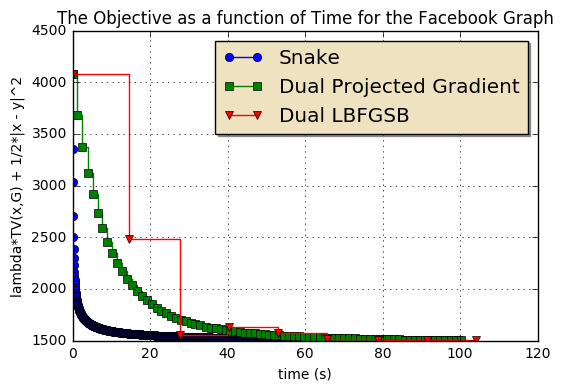

In [14]:
%matplotlib inline
snake = plt.plot(SnakeTV[('time',lgr)],SnakeTV[('Obj',lgr)],drawstyle='steps-post',marker = 'o',label = 'Snake')
pg = plt.plot(PG['time'],PG['Obj'],drawstyle='steps-post',marker = 's',label='Dual Projected Gradient')
bfgs = plt.plot(BFGS['time'],BFGS['Obj'],drawstyle='steps-post',marker = 'v',label='Dual LBFGSB')
 

plt.xlabel('time (s)')
plt.ylabel('lambda*TV(x,G) + 1/2*|x - y|^2')
plt.title('The Objective as a function of Time for the Facebook Graph')
legend = plt.legend(loc = 0, shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('#efe2c1')
#plt.axis([0, 75, 1000, 4500])
#plt.xscale('log')
plt.grid()
plt.savefig('FB-review.png')
plt.show()


# Laplacian risk minimization : Harmonic energy minimization

In [19]:
#Data

#Vector of unobserved nodes
vec0 = snap.TIntV() 
for v in G.Nodes():
    k = v.GetId() 
    if k < G.GetNodes()/2:
        vec0.Add(v.GetId())
    
#Vector of observed nodes
vec1 = snap.TIntV()
for v in G.Nodes():
    k = v.GetId() 
    if k >= G.GetNodes()/2:
        vec1.Add(v.GetId())  
    
#Graph of observed nodes    
G1 = snap.GetSubGraph(G, vec1)

#Graph of unobserved nodes
G0 = snap.GetSubGraph(G, vec0)

#External degree in G0 of a node in G1
d1_ext = np.zeros(G.GetMxNId() - G.GetNodes()/2)
for v in G1.Nodes():
    k = v.GetId()
    v0 = G.GetNI(k)
    d1_ext[k - G.GetNodes()/2] = (v0.GetDeg() - v.GetDeg())

#External degree in G1 of a node in G0
d0_ext = np.zeros(G.GetNodes()/2)
for v in G0.Nodes():
    k = v.GetId()
    v1 = G.GetNI(k)
    d0_ext[k] = v1.GetDeg() - v.GetDeg()
    
print G0.GetMxNId(), G1.GetMxNId()

2019 4039


In [20]:
#Functions one need to apply the conjugate gradient algorithm 

#Computes the Laplacian value at x over G
def L(x,G):
    y = np.zeros(G.GetMxNId()+1)
    for v in G.Nodes():
        i = v.GetId()
        y[i] = v.GetDeg()*x[i] - sum([x[v.GetNbrNId(k)] for k in range(v.GetDeg())])
    return y

#Corresponds to the matrix D_G - A_G0 
def Mat(x,G0,G):
    y = np.zeros(G.GetNodes()/2)
    for v0 in G0.Nodes():
        i = v0.GetId()
        v = G.GetNI(i)
        y[i] = v.GetDeg()*x[i] - sum([x[v0.GetNbrNId(k)] for k in range(v0.GetDeg())]) 
    return y

#This vector will be useful in the sequel
Y = np.zeros(G.GetNodes()/2)
for v0 in G0.Nodes():
    i = v0.GetId()
    v = G.GetNI(i)
    Y[i] = sum([y[v.GetNbrNId(k)] for k in range(v.GetDeg()) if v.GetNbrNId(k) >= G.GetNodes()/2])


In [21]:
#Parameter

#We will run the algorithms during sec seconds
#sec = 4000 #for the Orkut graph
sec = 1.0 #for the Facebook graph

#x_test = np.asarray([np.mean(x1)]*len(x0))

In [23]:
#Snake for the Laplacian regularized risk minimization
R = 'Laplace'

#The dictionnary SnakeLaplace will contain the necessary material for the simulation visualization
SnakeLaplace = {}

#The step size is taken to be cte/sqrt(n) over the Orkut graph
#aj = 0.5
#cte = coeff/(aj*float(G.GetEdges()))
#n = 1
#gamma_n = cte /np.sqrt(float(n))

#The step size is taken to be cte/n over the Facebook graph
aj = 1.0
cte = coeff/(aj*float(G.GetEdges()))
n = 1
gamma_n = cte /float(n)


#lgr = L in the paper
lgr = G.GetNodes()/10 #one can take lgr = 100 if one wants smaller iterations
l = lgr

#lgr = G.GetNodes()/50 over the Orkut graph

#The gradient of the data fitting term in x0 is 2 * (x0*d0_ext - Y)

#The first iterate of the algorithm (vector x over G0) is chosen to be 0, 
#The vector of observed nodes is chosen to coincide with y on observed nodes
x0 = np.zeros(G.GetNodes()/2)
x1 = y[G.GetNodes()/2:G.GetMxNId()]



#The corresponding harmonic energy is zero_harmonic_energy
zero_harmonic_energy = Laplace(np.asarray(list(x0)+list(x1)),G)

#One can check that the harmonic energy of a vector x over G can be expressed 
#via its restriction x0 to G0 by the expression 
#zero_harmonic energy - 2*np.inner(x0,Y) + np.inner(x0,Mat(x0,G0,G))



#SnakeLaplace[('harmonic_energy',lgr)] contains the values of the harmonic energy 
#on the iterates of the algorithm. The first value is
SnakeLaplace[('harmonic_energy',lgr)] = [zero_harmonic_energy]

#SnakeLaplace[('time',lgr)] chronometers the running of the algorithm
SnakeLaplace[('time',lgr)] = [0]


#Initializing the random walk
e = Rnd_Edge(G0)

print SnakeLaplace[('time',lgr)][-1]

temps = time.time()
while SnakeLaplace[('time',lgr)][-1] < sec: 
    
    C, e = Simple_Path(e, l, G0)  
    x0 = x0 - gamma_n * (len(C) - 1) * 2 * (x0*d0_ext - Y)
    x0 = Prox_1D(x0, C, G0.GetEdges() * gamma_n, R)
    l = l - (len(C) - 1)
    
    
    if l == 0:
        l = lgr
        n += 1
        gamma_n = cte /np.sqrt(float(n))
        e = Rnd_Edge(G0)
        
        temps = time.time() - temps
        SnakeLaplace[('time',lgr)] += [SnakeLaplace[('time',lgr)][-1] + temps]
        print SnakeLaplace[('time',lgr)][-1]
        
        SnakeLaplace[('harmonic_energy',lgr)] += [zero_harmonic_energy + np.inner(x0,Mat(x0,G0,G) - 2*Y)]
        print SnakeLaplace[('harmonic_energy',lgr)][-1]
        
        temps = time.time()

0
0.00916886329651
97665.097386
0.016952753067
97651.84161
0.0244958400726
97643.8687257
0.0330998897552
97640.2859757
0.0408627986908
97638.1759607
0.0485117435455
97636.6348466
0.0559706687927
97635.4980747
0.0634546279907
97634.5195702
0.0712716579437
97634.6005615
0.0806455612183
97633.829117
0.0873565673828
97633.1982373
0.0955736637115
97632.7221405
0.103414535522
97632.2541977
0.111231565475
97632.808627
0.118526697159
97632.1982715
0.125734567642
97631.7744663
0.132965564728
97631.363366
0.140396595001
97631.0455255
0.148252725601
97630.8995533
0.155755758286
97631.5223775
0.16278886795
97630.6985679
0.170163869858
97630.3439243
0.178147792816
97630.2027875
0.184705972672
97629.9447648
0.192286968231
97629.8484195
0.199059009552
97629.7035397
0.206792831421
97629.4168601
0.213737010956
97629.2728317
0.220795869827
97629.1470843
0.231526851654
97632.5733866
0.238706827164
97631.6871606
0.246617794037
97630.47334
0.253797769547
97629.7057547
0.261246681213
97629.0833272
0.2684347

In [24]:
#Conjugate gradient for the Laplacian regularized risk minimization

#The dictionnary CG will contain the necessary material for the simulation visualization
CG = {}


#Our problem boils down to solving the linear system associated with the matrix Mat(.,G0,G) and the vector Y

#The first iterate of the algorithm (vector x over G0) is chosen to be 0, 
#The vector of observed nodes is chosen to coincide with y on observed nodes
x0 = np.zeros(G.GetNodes()/2)
x1 = y[G.GetNodes()/2:G.GetMxNId()]

#The corresponding harmonic energy is zero_harmonic_energy
zero_harmonic_energy = Laplace(np.asarray(list(x0)+list(x1)),G)

#One can check that the harmonic energy of a vector x over G can be expressed 
#via its restriction x0 to G0 by the expression 
#zero_harmonic energy - 2*np.inner(x0,Y) + np.inner(x0,Mat(x0,G0,G))


#CG['harmonic_energy'] contains the values of the harmonic energy 
#on the iterates of the algorithm. The first value is
CG['harmonic_energy'] = [zero_harmonic_energy]

#CG['time'] chronometers the running of the algorithm
CG['time'] = [0]


print CG['time'][-1]

#Initializing the conjugate gradient algorithm
tip = time.time()
Mx = np.zeros(G.GetNodes()/2) # = CG(x0,G0,G)
r = Y #- Lx
p = np.copy(r)
top = time.time()

print top - tip

while CG['time'][-1] < sec:
    
    temps = time.time()
    
    Mp = Mat(p,G0,G)
    
    print time.time() - temps
    
    alpha = (np.linalg.norm(r)**2) /(np.inner(p,Mp))
    x0 = x0 + alpha*p
    r1 = np.copy(r)
    r = r - alpha*Mp
    beta = (np.linalg.norm(r)**2)/(np.linalg.norm(r1)**2)
    p = r + beta*p
    Mx = Mx + alpha*Mp
    
    temps = time.time()-temps
    
    
    CG['time'] += [CG['time'][-1] + temps]
    print CG['time'][-1]
    
    CG['harmonic_energy'] += [zero_harmonic_energy + np.inner(x0,Mat(x0,G0,G) - 2*Y)]
    print CG['harmonic_energy'][-1]
    

0
0.000216007232666
0.052433013916
0.0526149272919
97696.4643112
0.0494229793549
0.102165937424
97660.199863
0.0512781143188
0.153583049774
97645.2114163
0.0508351325989
0.204528093338
97640.9843867
0.0520899295807
0.256740093231
97634.1790485
0.0505278110504
0.307380914688
97629.6292254
0.0585649013519
0.366060972214
97628.7562486
0.050626039505
0.4168009758
97627.2154433
0.0506381988525
0.467555046082
97625.7697608
0.0518600940704
0.519539117813
97625.0526811
0.0507838726044
0.57044005394
97624.7768208
0.0504379272461
0.620988130569
97624.6056603
0.0515570640564
0.672660112381
97624.4680356
0.050369977951
0.723176002502
97624.3864265
0.0507709980011
0.774064064026
97624.3274768
0.0499150753021
0.824090003967
97624.2773507
0.0572221279144
0.881669998169
97624.2334653
0.0489389896393
0.930712938309
97624.186733
0.0497591495514
0.980577945709
97624.1388692
0.0517270565033
1.03243994713
97624.0956793


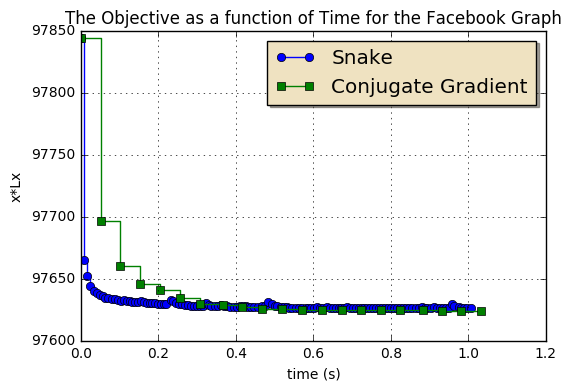

In [25]:
%matplotlib inline
snakeL = plt.plot(SnakeLaplace[('time',lgr)],SnakeLaplace[('harmonic_energy',lgr)],drawstyle='steps-post',marker = 'o',label = 'Snake')
cg = plt.plot(CG['time'],CG['harmonic_energy'],drawstyle='steps-post',marker = 's',label='Conjugate Gradient')
 

plt.xlabel('time (s)')
plt.ylabel('x*Lx')
plt.title('The Objective as a function of Time for the Facebook Graph') #Or Orkut Graph
legend = plt.legend(loc = 0, shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('#efe2c1')
#plt.axis([0, 75, 1000, 4500])
#plt.xscale('log')
plt.grid()
#plt.savefig('harmonic-FB.png')
plt.show()


# Laplacian risk minimization : Solving Lx = b

In [31]:
#Functions one need to apply the conjugate gradient algorithm 

#Computes the Laplacian value at x over G
def L(x,G):
    y = np.zeros(G.GetMxNId())
    for v in G.Nodes():
        i = v.GetId()
        y[i] = v.GetDeg()*x[i] - sum([x[v.GetNbrNId(k)] for k in range(v.GetDeg())])
    return y

b = np.copy(y)

In [28]:
#Parameter

#We will run the algorithms during sec seconds
sec = 36000 #for the Orkut graph
#sec = ??? #for the Facebook graph
sec = 1

In [34]:
#Snake for solving Lx = b
R = 'Laplace'

#The dictionnary SnakeLxb will contain the necessary material for the simulation visualization
SnakeLxb = {}


#The step size is taken to be cte/n over the Orkut graph
aj = 4.0
cte = coeff/(aj*float(G.GetEdges()))
n = 1
gamma_n = cte / float(n)


#lgr = L in the paper
lgr = G.GetNodes()
l = lgr

#The first iterate of the algorithm is chosen to be 0 or b
x = np.zeros(N)
#x = np.copy(b)
Lx = L(x,G)


#SnakeLxb[('distance',lgr)] contains the values of the distance |Lx - b| at the iterate x of the algorithm 
SnakeLxb[('distance',lgr)] = [np.linalg.norm(Lx - b)]

#SnakeLxb[('time',lgr)] chronometers the running of the algorithm
SnakeLxb[('time',lgr)] = [0]



#Initializing the random walk
e = Rnd_Edge(G0)

print SnakeLxb[('time',lgr)][-1]

temps = time.time()
while SnakeLxb[('time',lgr)][-1] < sec: 
    
    C, e = Simple_Path(e, l, G)  
    x = x + gamma_n * (len(C) - 1) * b
    x = Prox_1D(x, C, G.GetEdges() * gamma_n, R)
    l = l - (len(C) - 1)
    
    if l == 0:
        l = lgr
        n += 1
        gamma_n = cte /(float(n))
        e = Rnd_Edge(G)
        
        temps = time.time() - temps
        SnakeLxb[('time',lgr)] += [SnakeLxb[('time',lgr)][-1] + temps]
        print SnakeLxb[('time',lgr)][-1]
        
        SnakeLxb[('distance',lgr)] += [np.linalg.norm(L(x,G)-b)]
        print SnakeLxb[('distance',lgr)][-1]
        
        temps = time.time()

0
0.0641961097717
47.5509920681
0.12899518013
44.6402258924
0.196259260178
41.5974226376
0.263414382935
41.0642216468
0.344933271408
40.9046913464
0.416190385818
41.0717495034
0.484221458435
40.4820515043
0.553476333618
40.5696193487
0.623284339905
40.2226619159
0.695377349854
40.5637725949
0.764649391174
40.2110704363
0.832570314407
40.5557896374
0.912971258163
39.3548015689
0.977334260941
39.3610684918
1.04695820808
39.5105227757
1.1202352047
38.7356639286
1.19885706902
39.3405647411
1.27283406258
38.6709278849
1.34138512611


KeyboardInterrupt: 

In [36]:
#Conjugate gradient for the resolution of Lx = b

#The dictionnary Lxb will contain the necessary material for the simulation visualization
Lxb = {}

#We want to solve the linear system associated with the matrix L(.,G) and the vector b

#The first iterate of the algorithm is chosen to be 0 or b
x = np.zeros(N)
#x = np.copy(b)
Lx = L(x,G)


#Lxb['distance'] contains the values of the distance |Lx - b| at the iterate x of the algorithm 
Lxb['distance'] = [np.linalg.norm(Lx - b)]

#Lxb['time'] chronometers the running of the algorithm
Lxb['time'] = [0]


print Lxb['time'][-1]

#Initializing the conjugate gradient algorithm
tip = time.time()
r = b - Lx
p = np.copy(r)
top = time.time()

print top - tip


while Lxb['time'][-1] < sec:
    
    temps = time.time()
    
    Lp = L(p,G)
    
    print time.time() - temps
    
    alpha = (np.linalg.norm(r)**2) /(np.inner(p,Lp))
    x = x + alpha*p
    r1 = np.copy(r)
    r = r - alpha*Lp
    beta = (np.linalg.norm(r)**2)/(np.linalg.norm(r1)**2)
    p = r + beta*p
    Lx = Lx + alpha*Lp
    
    temps = time.time()-temps
    
    
    Lxb['time'] += [Lxb['time'][-1] + temps]
    print Lxb['time'][-1]
    
    Lxb['distance'] += [np.linalg.norm(Lx - b)]
    print Lxb['distance'][-1]
    

0
0.00019907951355
0.106974840164
0.107182979584
85.3034948525
0.109000921249
0.216475963593
93.0047665409
0.108745098114
0.325348138809
88.6013669782
0.111910104752
0.437527179718
61.4716039915
0.109817028046
0.547475337982
53.9823113165
0.118297100067
0.666105508804
65.6912512549
0.108412981033
0.774662494659
56.7681652957
0.110315084457
0.885300397873
53.4476741359
0.107795000076
0.993239402771
43.6123033761
0.106782913208
1.10031533241
40.7408999325
0.108242988586
1.20868444443
38.0984134801
0.110100984573
1.31903457642
38.3132037505
0.109929084778
1.42913556099
33.0648260148
0.111922025681
1.54132175446
29.5998088629
0.110485076904
1.65195178986
27.7297770415
0.111039161682
1.7632317543
25.7045394241
0.106935024261
1.87029290199
23.1161036181
0.109704971313
1.98023200035
21.9355650815
0.107954025269
2.08831000328
21.3928190884
0.106328964233
2.19501399994
19.2809883424
0.105746984482
2.30088806152
33.8377173369
0.111578941345
2.41320419312
16.5935983789
0.11301612854
2.52640032768

KeyboardInterrupt: 

In [43]:
print len(Lxb['distance']),len(Lxb['time']),len(SnakeLxb[('distance',lgr)]),len(SnakeLxb[('time',lgr)])


37 37 18 18


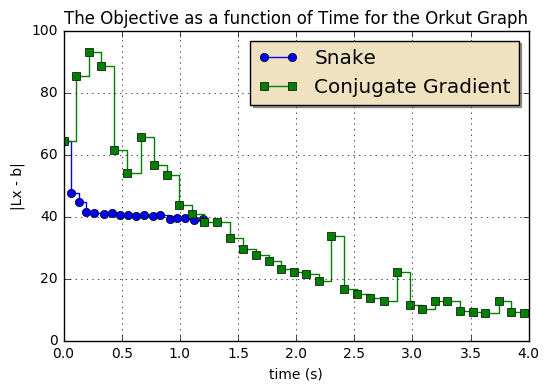

In [44]:
%matplotlib inline
snakeLxb = plt.plot(SnakeLxb[('time',lgr)],SnakeLxb[('distance',lgr)],drawstyle='steps-post',marker = 'o',label = 'Snake')
cglxb = plt.plot(Lxb['time'],Lxb['distance'],drawstyle='steps-post',marker = 's',label='Conjugate Gradient')
 

plt.xlabel('time (s)')
plt.ylabel('|Lx - b|')
plt.title('The Objective as a function of Time for the Orkut Graph')
legend = plt.legend(loc = 0, shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('#efe2c1')
#plt.axis([0, 75, 1000, 4500])
#plt.xscale('log')
plt.grid()
#plt.savefig('Lxb-Orkut.png')
plt.show()
